# Crime and Weather

Simple question: how does temperature affect crime rates?

Since daily temperature variations are "fairly random," I think there's actually a fairly compelling causal story in this case.

To answer this, we'll use:
* Historical data from the [Weather Underground API](https://www.wunderground.com/weather/api/d/docs?d=data/history).  We will have to get this data piece by piece.  We can get 500 requests per day with the free API -- basically a year's worth.  So we can download one year at a time.  (The more-sophisticated way to do this is to set up a "cron" job on a Mac or Task Scheduler job on Windows.)
  * I have made a "fake API" for 2015, replacing: 
    http://api.wunderground.com/api/MY_API_KEY/history_20150101/q/KMDW.json<br>
    with: https://raw.githubusercontent.com/harris-ippp/lectures/master/09-weather/data/wu/history_20150101/q/KMDW.json    
* Crime APIs and data from:
  * Chicago: https://dev.socrata.com/foundry/data.cityofchicago.org/6zsd-86xi
  * Philadelphia: https://cityofphiladelphia.github.io/carto-api-explorer/#incidents_part1_part2
  * Phoenix: https://www.phoenix.gov/OpenDataFiles/Crime%20Stats.csv
  * Dallas: https://dev.socrata.com/foundry/www.dallasopendata.com/qqc2-eivj
  * San Francisco: https://dev.socrata.com/foundry/data.sfgov.org/cuks-n6tp
  
  Except Phoenix, these APIs all have SQL-like interfaces.  We can just the data that we need, through the databases.

Here are our standard imports: we'll want pandas, requests, datetime, statsmodels, seaborn.

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np

import requests, json

import pandas as pd
import seaborn as sns
sns.set_style("whitegrid", rc={'axes.linewidth': 2.5})
sns.set_context('notebook', font_scale=1.45, rc={"lines.linewidth": 3, "figure.figsize" : (7, 3)})

import pytz
import datetime

from urllib.parse import quote

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.regression.mixed_linear_model as sm_mlm

from time import sleep

## Weather in Chicago
We are well-acquainted with the correlated variation in crime and weather, in Chicago.  But how do we get that data?  We'll have to loop through days (and airports).  Since we can only get one year at a time, we'll have to cache all of this.

To do this, we'll use the [`datetime`](https://docs.python.org/3.5/library/datetime.html) package: `date` and `timedelta`.

```
date = datetime.date(2015, 1, 1)
```

and 

```
date + datetime.timedelta(d)
```

The "make-believe" endpoint is:
```
https://raw.githubusercontent.com/harris-ippp/lectures/master/09-weather/data/wu/history_{}/q/K{}.json
```

Let's begin by examining a single json response

* Extract (write to file) from this response the time, precipitation, and temperature for each observation.  Assume that the negative precipitation is balderdash.
* Then do this for every day in 2015 (the only year for which the "pretend endpoint" is set up).

When this is all done, `cat` them all together:

```
cat MDW/*csv > MDW.csv
```

Since we wanted more data, I've done this for 15 years of data, and stashed this in `data/MDW.csv`.  Let's import that data.  We'll have to do `index_col`, `names`, and `parse_dates`:

In [41]:
weather_mdw = pd.read_csv("data/MDW.csv", parse_dates = ["Date"], 
                          index_col = "Date",
                          names = ["Date", "Temperature [F]", "Precipitation [In]"])

weather_mdw.head()

,Temperature [F],Precipitation [In]
Date,,
2001-01-01 06:53:00,19.0,0.0
2001-01-01 07:53:00,19.0,0.0
2001-01-01 08:53:00,18.0,0.0
2001-01-01 09:53:00,17.1,0.0
2001-01-01 10:53:00,14.0,0.0


We saw this last week as well, but we'll need to "localize" the time from UTC to US/Central:

In [42]:
weather_mdw.set_index(weather_mdw.index.tz_localize(pytz.UTC).tz_convert(pytz.timezone('US/Central')), inplace = True)

Plot this and make sure everything looks alright -- apply any necessary masks.

Finally, resample at the one-day level (`df.resample("1D").mean()`) and replot.

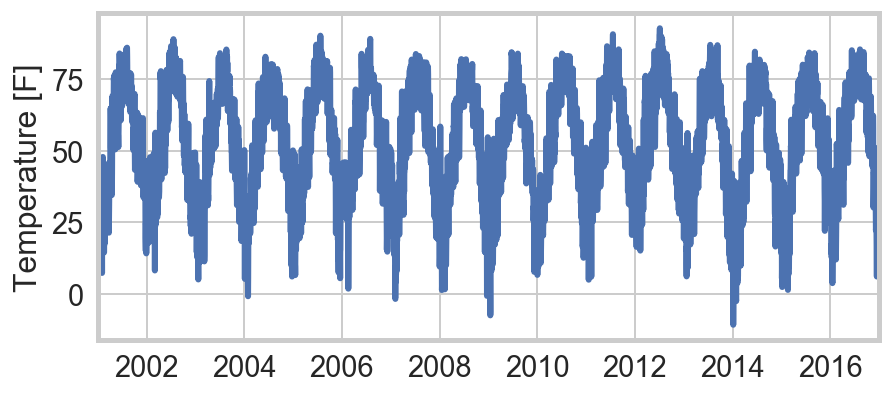

## City Crime Data

### Chicago

You downloaded a big chunk of the city's crime data to do your pandas homework.

We can't do that today -- too much data.  But to start, all we want are the [dates](https://dev.socrata.com/docs/datatypes/floating_timestamp.html#) and the crime counts.

We can get this from the APIs, using SoQL queries (Socrata Query Language ~ SQL): basically, SQL without `FROM` statements.

https://dev.socrata.com/foundry/data.cityofchicago.org/6zsd-86xi

https://dev.socrata.com/docs/queries/

We'll use `urllib.parse.quote` to encode URLs: change spaces to %20, etc.

We'll group by date, and count rows: `Count(*) AS Count`.

Be careful not to "hammer" the API.  With a token you get ~unlimited calls, but without one it's quite restricted.

By default the limit is 1000 rows.  Here, we're asking for daily observations for 14 years, around 5000 rows.

https://data.cityofchicago.org/resource/6zsd-86xi.json?$query=SELECT%20date_trunc_ymd%28date%29%20AS%20Date%2C%20count%28%2A%29%20AS%20Count%20WHERE%202002%20%3C%20year%20AND%20year%20%3C%202017%20GROUP%20BY%20Date%20ORDER%20BY%20Date%20LIMIT%2010000


Now format these data.  Specifically: convert `Date` to a date (`pd.to_datetime(df.Date)`) and `Count` to an `int`.

,Count
Date,
2003-01-01,2021
2003-01-02,1170
2003-01-03,1298
2003-01-04,1197
2003-01-05,1149


Localize the time!!

In [57]:
daily_crimes.set_index(daily_crimes.index.tz_localize(pytz.timezone('US/Central')), inplace = True)

Plot the data.  Make sure you label your axes!

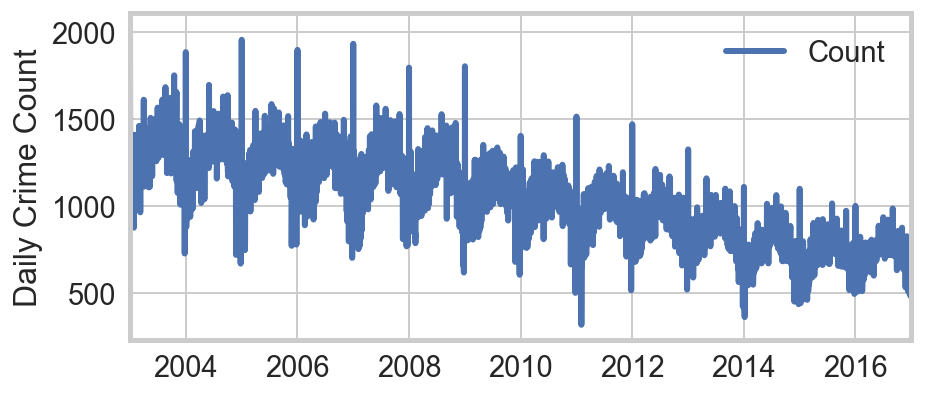

To see it a little more clearly, resample to the one-month level: `df.resample("1M").sum()`.

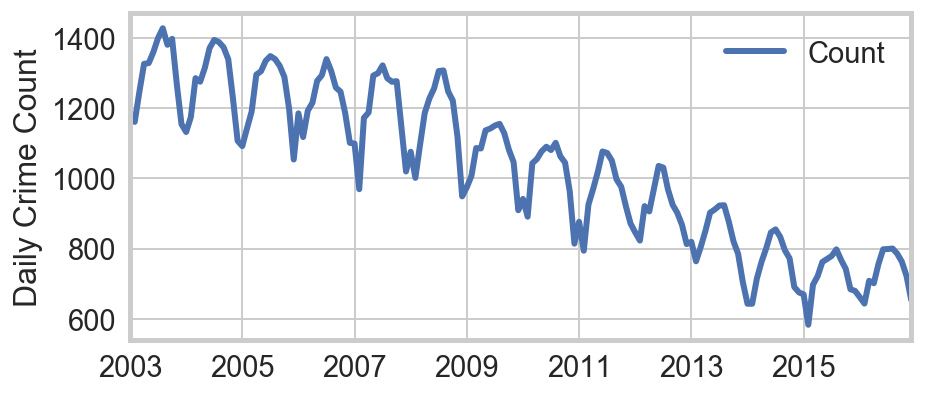

We should see a clear seasonal "oscillation" here.  But is this just an efect of longer evening hours?  Or rowdy kids free from school?

### Warm Places: It's Not Sunlight
Loading crime data from San Francisco, Dallas, and Phoenix (grouped at the monthly level) suggests that the temperature variations are actually important: it's not just daylight or the school calendar.

We'll do each of these more or less in passing.

San Francisco: https://dev.socrata.com/foundry/data.sfgov.org/cuks-n6tp

Use a `WHERE` clause to exclue non-criminal incidents.

Plot the monthly rates.

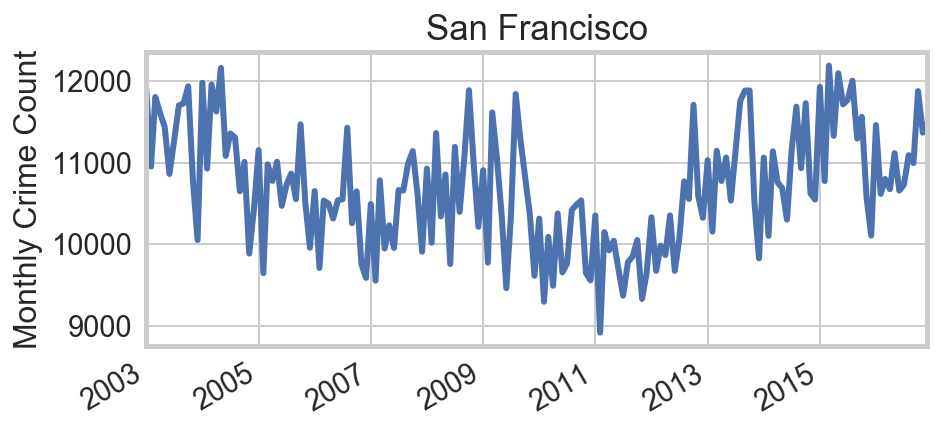

In [14]:
ax = sf_crime["Count"].plot(x = "Month", y = "Count", title = "San Francisco")
ax.set_ylabel("Monthly Crime Count")
ax.set_xlabel("");

No trend here!

For Phoenix, they just supply a file.  Let's download that and load it up.

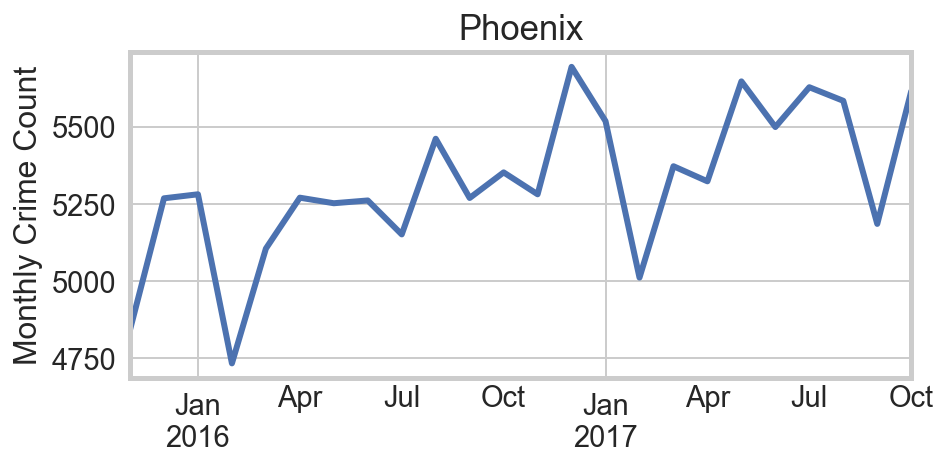

In [15]:
# ! curl https://www.phoenix.gov/OpenDataFiles/Crime%20Stats.csv -o "data/phoenix_az.csv"

phoenix_crime = pd.read_csv("data/phoenix_az.csv",
                            parse_dates = ["OCCURRED ON"], infer_datetime_format = True,
                            index_col = "OCCURRED ON", usecols = ["UCR CRIME CATEGORY", "OCCURRED ON"])

phoenix_crime = phoenix_crime[phoenix_crime.index < datetime.datetime(2017, 11, 1)]
ax = phoenix_crime["UCR CRIME CATEGORY"].resample("1M").count().plot(title = "Phoenix")
ax.set_ylabel("Monthly Crime Count")
ax.set_xlabel("");

And likewise for Dallas -- reject accidents and non-offenses:
```
WHERE offincident NOT LIKE '%NO OFFENSE%' AND offincident NOT LIKE '%ACCIDENT INV%' 
```

In [16]:
dal_url =  "https://www.dallasopendata.com/resource/qqc2-eivj.json?$query="
dal_url += quote("SELECT date_trunc_ym(date1) AS date, count(*) AS count ")
dal_url += quote("WHERE offincident NOT LIKE '%NO OFFENSE%' AND offincident NOT LIKE '%ACCIDENT INV%' ")
dal_url += quote("GROUP BY date ORDER BY date")

dal = pd.read_json(dal_url, convert_dates = ["date"])
dal.set_index("date", inplace = True)

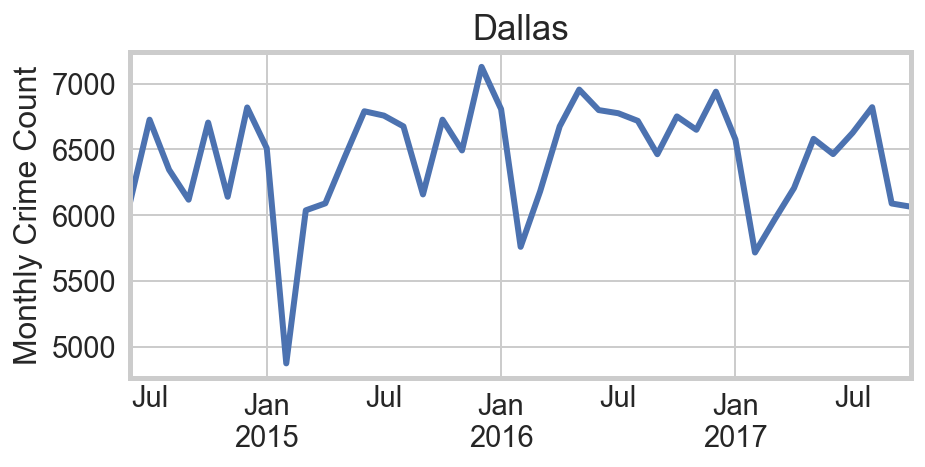

In [17]:
mask = (dal.index >= datetime.datetime(2014, 6, 1)) & \
       (dal.index <  datetime.datetime(2017, 11, 1))

ax = dal.loc[mask, "count"].plot(title = "Dallas")
ax.set_ylabel("Monthly Crime Count")
ax.set_xlabel("")

Phoenix and Dallas do seem to show drops in February -- but of around 10%, instead of the 25-35% drops from Chicago.  

The greatest city in the world also has real seasons.  So let's see what happens there.

Like a real prize fighter, Philadelphia uses genuine SQL (Postgres variety).  The table to `FROM` from is `incidents_part1_part2`.  Unfortunately, the date is just a string, and we have to "edit" it.  

* https://cityofphiladelphia.github.io/carto-api-explorer/#incidents_part1_part2

In [18]:
phl_url =  "https://phl.carto.com/api/v2/sql?q="
phl_url += "SELECT CONCAT(SUBSTRING(dispatch_date FROM 0 FOR 8), '-01') AS date, COUNT(*) AS count "
phl_url += "FROM incidents_part1_part2 GROUP BY date;"

resp = requests.get(phl_url).json()

In [19]:
phl_crime = pd.read_json(json.dumps(resp["rows"]), convert_dates = ["date"])
phl_crime.set_index("date", inplace = True)
phl_crime = phl_crime[phl_crime.index < datetime.datetime(2017, 1, 1)]

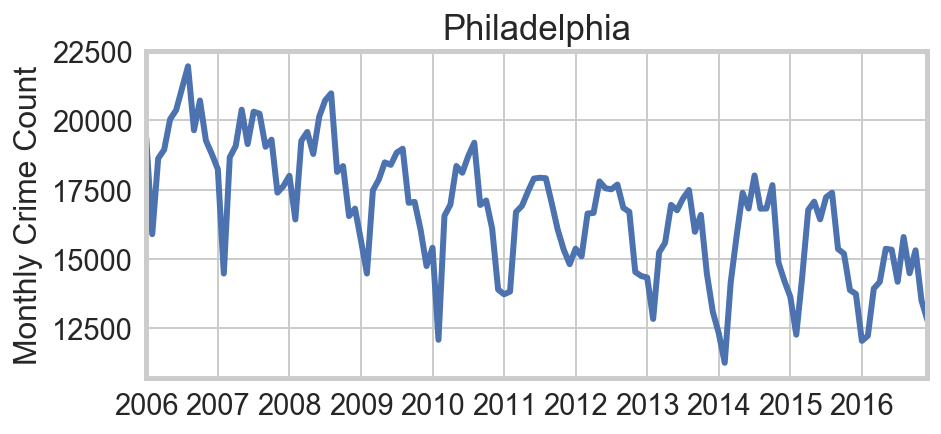

In [20]:
ax = phl_crime["count"].resample("1M").sum().plot(title = "Philadelphia")
ax.set_xlabel("")
ax.set_ylabel("Monthly Crime Count");

Great job, Philly -- those are some collosal seasonal variations in criminality.

## Wednesday: The Fun Stuff.

In [3]:
weather_mdw = pd.read_csv("data/MDW.csv", parse_dates = ["Date"], 
                          index_col = "Date",
                          names = ["Date", "Temperature [F]", "Precipitation [In]"])

weather_mdw.set_index(weather_mdw.index.tz_localize(pytz.UTC).tz_convert(pytz.timezone('US/Central')), inplace = True)

weather_mdw = weather_mdw[weather_mdw["Temperature [F]"] > -500]
weather_mdw = weather_mdw.resample("1D").mean()


with open("data/chicago_daily.csv") as data: resp = json.load(data)
    
daily_crimes = pd.DataFrame(resp)
daily_crimes.Date = pd.to_datetime(daily_crimes.Date)
daily_crimes.Count = daily_crimes.Count.astype(int)
daily_crimes.set_index("Date", inplace = True)

daily_crimes.set_index(daily_crimes.index.tz_localize(pytz.timezone('US/Central')), inplace = True)

### The Question is, what drives the variation?
Is it the absolute temperature only?  Or can the relative temperature (today is a nice day) also affect it?  Let's construct a few measures: use `df.shift(±1)` to get yesterday's or tomorrow's weather.  We can't _just_ use yesterday, since that will have a seasonal variation.

We'll also have to do a `dropna()`, since this won't be defined on the edge days.

There do not seem to be significant trends in the short-term shift comparisons, by season.

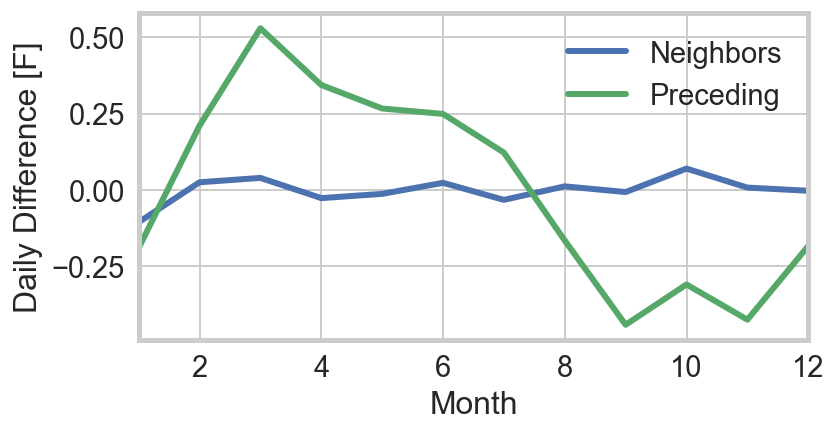

In [22]:
ax = weather_mdw["Daily Diff [F]"].groupby(weather_mdw.index.month).mean().plot(figsize = (6, 3), label = "Neighbors")
ax = weather_mdw['Yesterday Diff [F]'].groupby(weather_mdw.index.month).mean().plot(figsize = (6, 3), label = "Preceding")
ax.set_xlabel("Month");
ax.set_ylabel("Daily Difference [F]");
ax.legend()

Create similar ratios for crime:  We want to be able to look for changes in the daily crime counts, from daily temperature changes.

In [23]:
daily_crimes['Two Week Split [Count]'] = 0.5 * (daily_crimes['Count'].rolling(window = 7, center = False).mean().shift(-7) +
                                                daily_crimes['Count'].rolling(window = 7, center = False).mean().shift(1))

daily_crimes['Two Week Ratio [Count]'] = daily_crimes['Count'] / daily_crimes['Two Week Split [Count]']
daily_crimes.dropna(inplace = True)

Merge the two datasets.  Crime and year variables will be useful, since there are strong trends by year in the Chicago data.

To specify our model create variables for Month, Year (floating point), Yint (integers for categoricals), Day of Week (DoW), and a boolean for precipitation.

Do simple regplot of this with temperature and count.  There is very clear tempeature dependence, but also a huge spread.  Most of this is presumably from the secular trend over time.

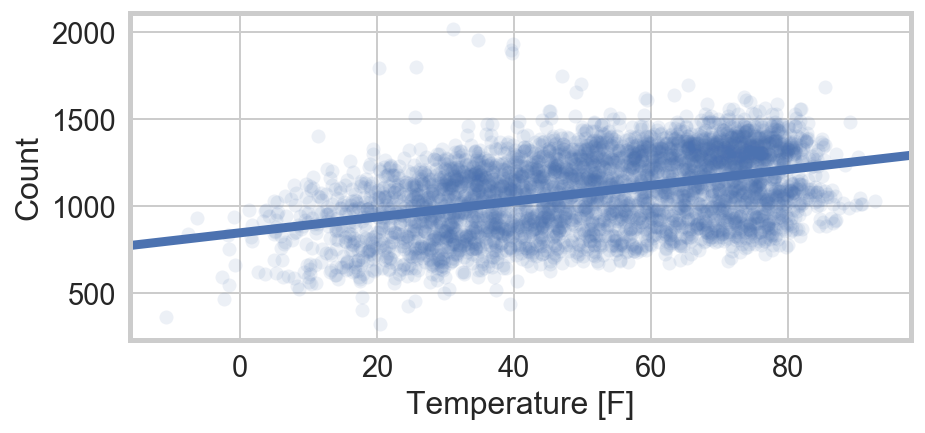

The coefficient on the temperature is highly significant.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     NC   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     1211.
Date:                Mon, 20 Nov 2017   Prob (F-statistic):               0.00
Time:                        01:13:17   Log-Likelihood:                -25629.
No. Observations:                4372   AIC:                         5.130e+04
Df Residuals:                    4351   BIC:                         5.143e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1058.2770      6.486    163.157      0.000    1045.561    1070.993
C(Yint)[T.2004]   -25.9866      6.312     -4.117      0.000     -38.361     -13.612
C(Yint)[T.2005]   -72.4321      6.317    -11.466      0.000     -84.817     -60.047
C(Yint)[T.2006]   -89.5686      6.323    -14.167      0.000    -101.964     -77.173
C(Yint)[T.2007]  -115.3905      6.325    -18.242      0.000    -127.792    -102.989
C(Yint)[T.2008]  -133.6533      6.313    -21.171      0.000    -146.030    -121.277
C(Yint)[T.2009]  -223.9090      6.320    -35.427      0.000    -236.300    -211.518
C(Yint)[T.2010]  -298.5570      6.321    -47.235      0.000    -310.949    -286.165
C(Yint)[T.2011]  -346.3127      6.326    -54.741      0.000    -358.716    -333.910
C(Yint)[T.2012]  -410.7983      6.329    -64.907      0.000    -423.206    -398.390
C(Yint)[T.2013]  -463.1341      6.316    -73.331      0.000    -475.516    -450.752
C(Yint)[T.2014]  -546.0670      6.325    -86.331      0.000    -558.468    -533.666
P[T.True]         -30.8909      2.779    -11.116      0.000     -36.339     -25.443
C(DoW)[T.1]        24.9476      4.825      5.171      0.000      15.488      34.407
C(DoW)[T.2]        36.0689      4.822      7.480      0.000      26.616      45.522
C(DoW)[T.3]        23.1145      4.824      4.792      0.000      13.657      32.572
C(DoW)[T.4]        82.6648      4.829     17.120      0.000      73.198      92.131
C(DoW)[T.5]        17.4921      4.826      3.624      0.000       8.030      26.954
C(DoW)[T.6]       -46.5342      4.824     -9.647      0.000     -55.991     -37.077
T                   4.6654      0.067     69.182      0.000       4.533       4.798
DD                 -1.0324      0.292     -3.539      0.000      -1.604      -0.460
==============================================================================
Omnibus:                     1811.042   Durbin-Watson:                   1.505
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            47441.842
Skew:                           1.399   Prob(JB):                         0.00
Kurtosis:                      18.894   Cond. No.                         692.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Let's examine the residuals as a function of temperature.  For this, we can use `sns.regplot()`, but supply two series, instead of x and y strings, and a DataFrame.

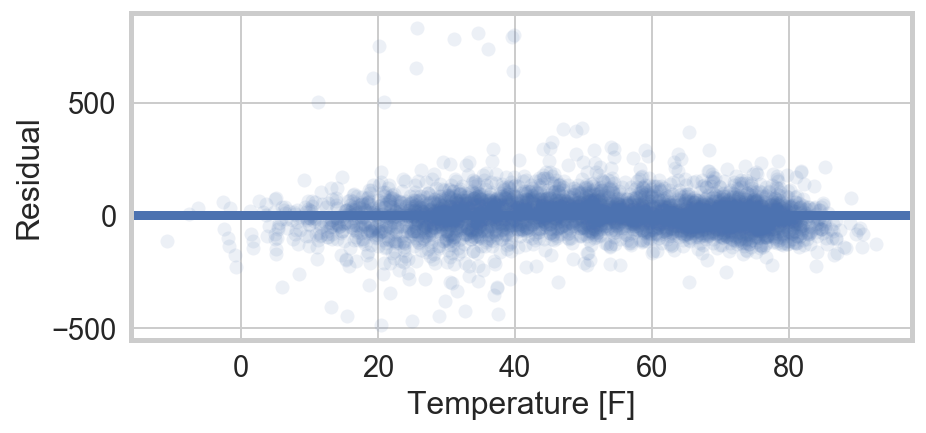

Let's also do a component + residual plot, with a linear regression, and a local regression.  This should make the apparent change in slope stand out...

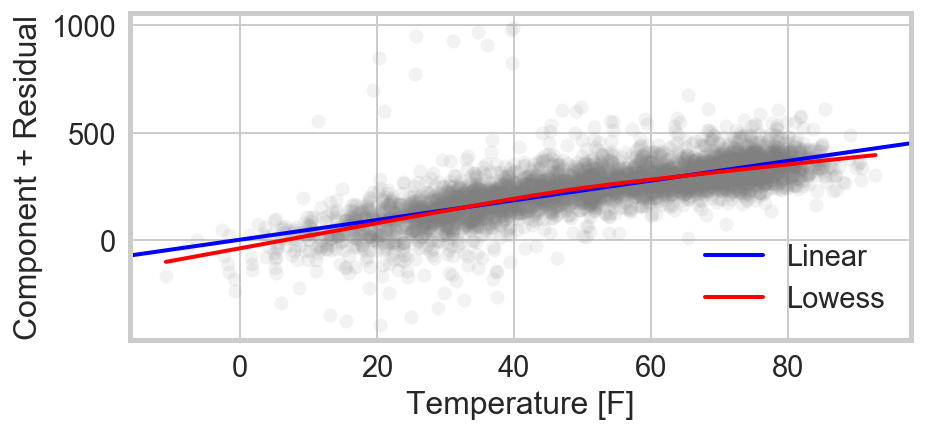

There are some pretty striking outliers here -- they're basically all January 1.  We'll come back to this.

DatetimeIndex(['2003-01-01 06:00:00+00:00', '2004-01-01 06:00:00+00:00',
               '2005-01-01 06:00:00+00:00', '2006-01-01 06:00:00+00:00',
               '2007-01-01 06:00:00+00:00', '2008-01-01 06:00:00+00:00',
               '2009-01-01 06:00:00+00:00', '2010-01-01 06:00:00+00:00',
               '2011-01-01 06:00:00+00:00', '2012-01-01 06:00:00+00:00',
               '2013-01-01 06:00:00+00:00', '2014-01-01 06:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Date', freq=None)

# Outliers -- January 1

A very natural explanation for outliers is that there is just a coding problem -- or a ton of crimes without valid dates that just get set to the beginning of the year.

There could also be categories of crime -- for instance, financial crimes -- with less-precise timestamps, that are simply set to January.

To start, let's comapre New Year's Day with the rest of January.  We can write queries to do most of the work for us, within the city's SoQL database!

There is one trick here: SoQL doesn't do the automatic bool → int conversion, so it won't do a sum for us of booleans.  We have to "manually" convert it using 

```
sum(case(date_extract_d(date) = 1, 31, true, 0))
```

Just as an alternative, we could have done a ton of this with grep etc.:

In [32]:
# ! cat /media/jsaxon/brobdingnag/data/crime/chicago_il.csv | grep ",01\/01\/20[01][0-9]" | cut -f6 -d, | sort | uniq -c | sort -n | sed "s/^ *\([0-9]*\) /\1,/" > data/new_years_crime.csv
# ! cat /media/jsaxon/brobdingnag/data/crime/chicago_il.csv | grep ",01\/[0-3][0-9]\/20[01][0-9]" | cut -f6 -d, | sort | uniq -c | sort -n| sed "s/^ *\([0-9]*\) /\1,/" > data/january_crime.csv

Now plot a bar chart, with the ratios for January 1st with respect to the rest of the month.

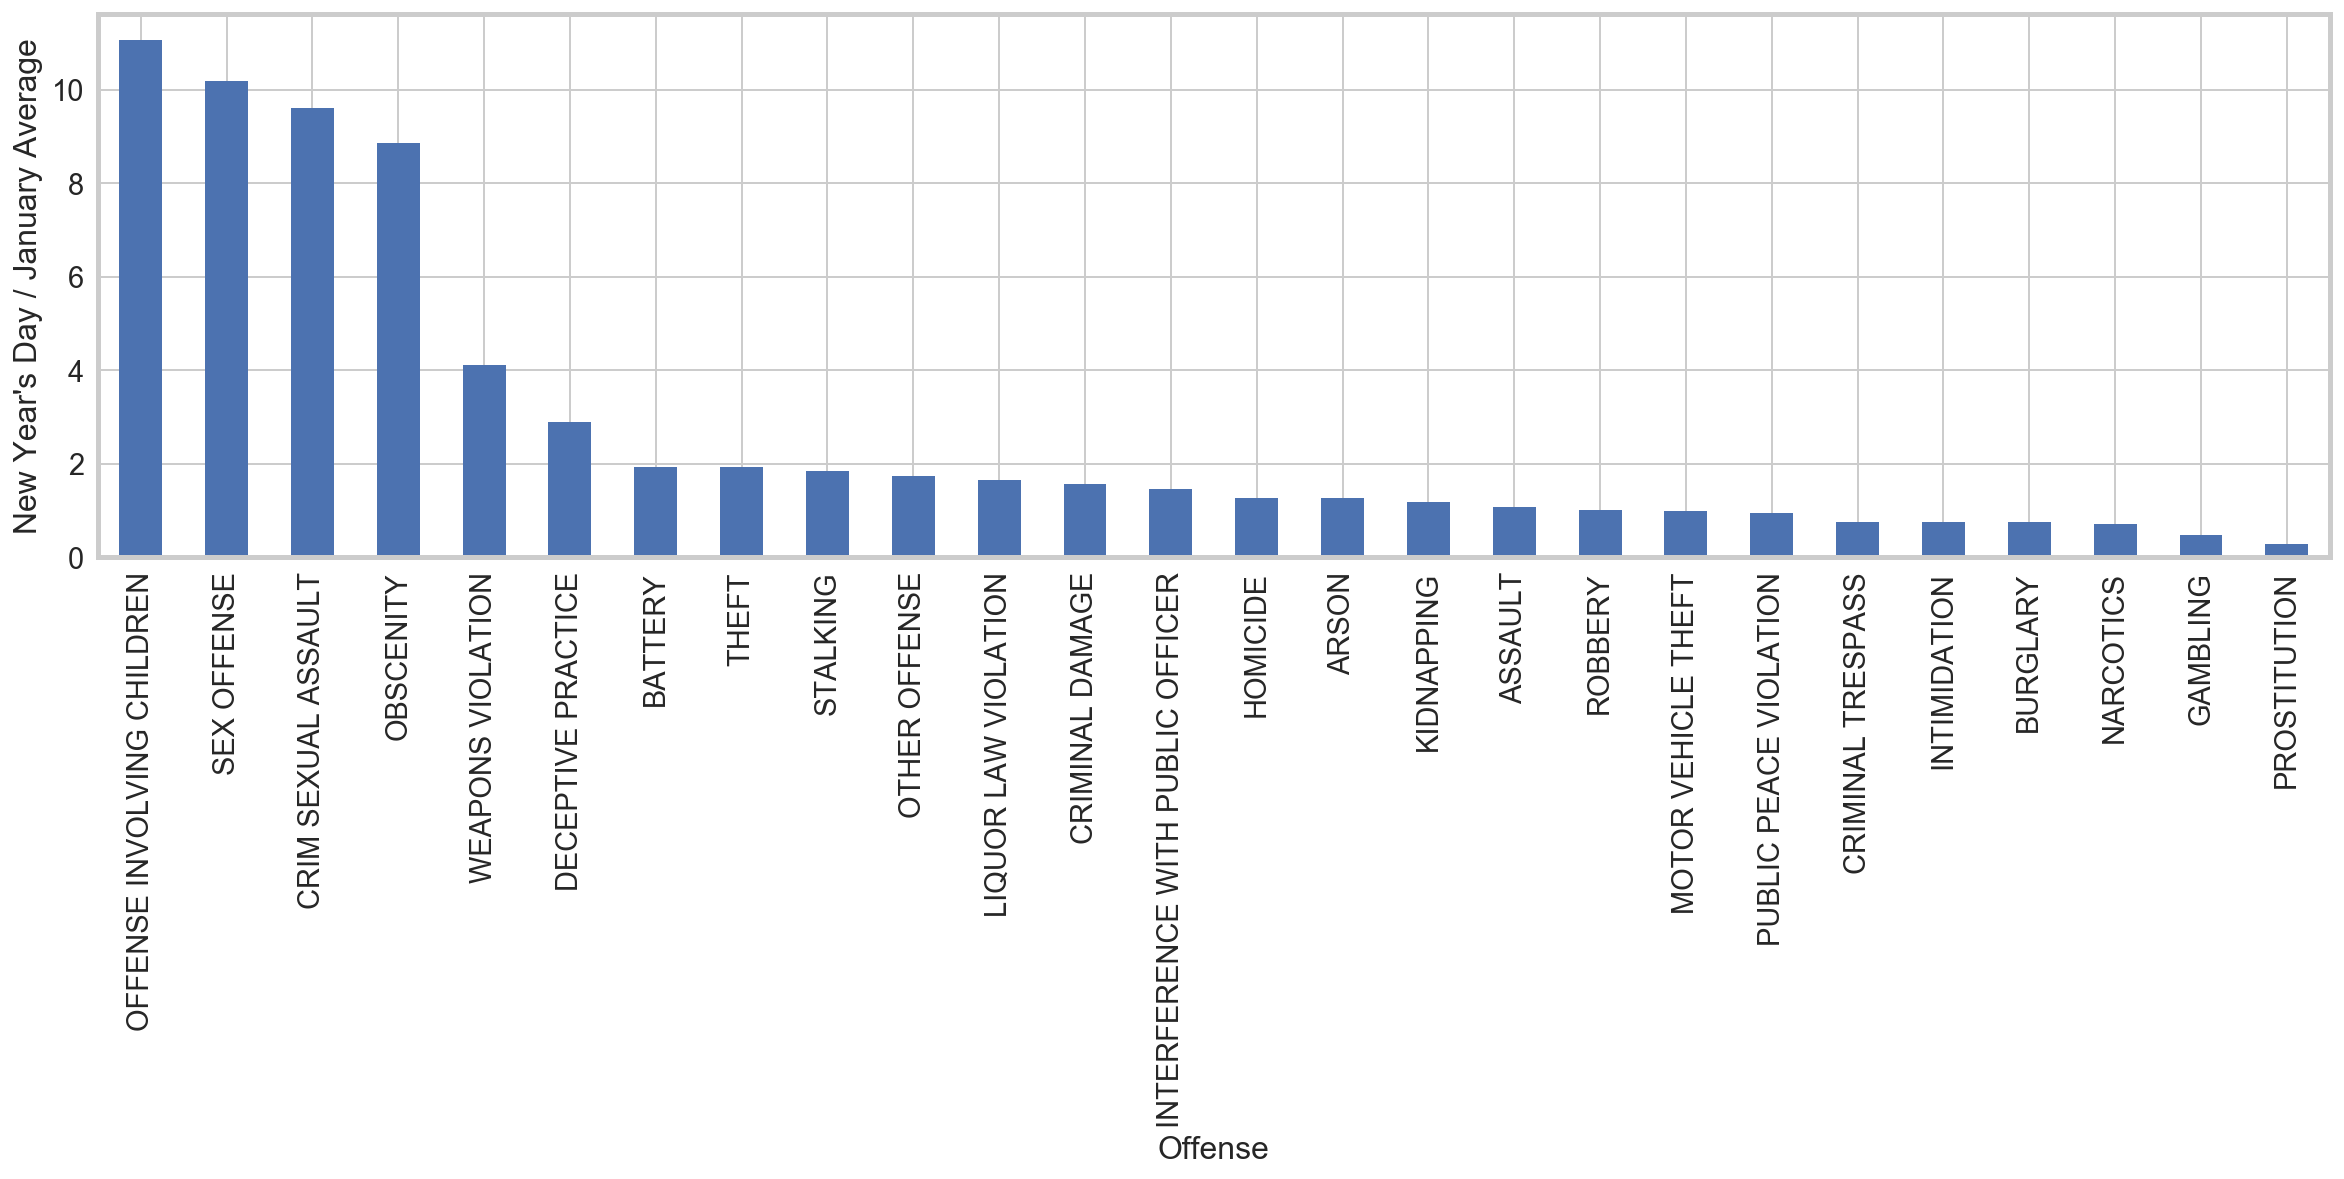

What about the most common types of crime?  Are their ratios also large?

,Offense,NJanuary,Ratio
0,THEFT,83126,1.936614
1,BATTERY,68150,1.942333
2,NARCOTICS,50950,0.719176
3,CRIMINAL DAMAGE,43029,1.561203
4,OTHER OFFENSE,28668,1.749616
5,BURGLARY,23781,0.749548
6,ASSAULT,22001,1.086360
7,MOTOR VEHICLE THEFT,20587,0.995337
8,DECEPTIVE PRACTICE,16549,2.894133
9,ROBBERY,15773,1.014138


OK, well this is not something I wanted to know about New Year's: high crime across the board, but particularly sex crimes and crimes involving children.  Nevertheless, the "overall" excess of crimes comes from the usual heavy hitters -- theft and battery.

# Various Types of Crime

Which types of crimes are most correlated with temperature, after controlling for the large overall drops over time?

As an alternative to the SoQL databases, we could do a ton of this via grep:

In [35]:
# # This is just wildly faster by command line.
# ! cat /media/jsaxon/brobdingnag/data/crime/chicago_il.csv | tail -n +2\
#       | cut -f3,6 -d, \
#       | sed "s/\([01][0-9]\)\/\([0-3][0-9]\)\/\(20[01][0-9]\)/\3\/\1\/\2/" \
#       | sed "s/ [01][0-9]:[0-5][0-9]:[0-5][0-9] [AP]M//" | sort | uniq -c \
#       | sed -e "s/ *//" -e "s/ /,/" \
#       > chicago_crime_types.csv

Import this (pre-processed, this time) data:

In [ ]:
chicago_types = pd.read_csv("data/chicago_crime_types.csv", 
                            parse_dates = ["Date"],
                            names = ["Count", "Date", "Type"])

Make a list of the common types of crime (top 20 occurrences).

Add a year variable and a day of week variable, to use in our regression.

Merge this to weather_mdw.

Now, for each type of crime (from the 20 common ones), measure the correlation coefficient of the temperature after removing the long-term trend.

In [38]:
from sklearn import linear_model # could have done: smf.ols, scipy.stats.linregress, 
from scipy import stats



,Offense,R,p
0,BATTERY,0.630988,0.000000e+00
1,ASSAULT,0.612371,0.000000e+00
2,THEFT,0.551994,0.000000e+00
3,CRIMINAL DAMAGE,0.505570,0.000000e+00
4,GAMBLING,0.441984,1.919755e-190
5,ROBBERY,0.367424,3.607561e-163
6,BURGLARY,0.349167,1.724808e-146
7,PUBLIC PEACE VIOLATION,0.299926,1.314005e-106
8,WEAPONS VIOLATION,0.242907,1.600327e-69
9,INTERFERENCE WITH PUBLIC OFFICER,0.201151,3.919752e-39


# Non-Linear Least Squares
Try a kink or a quadratic to find the "best" temperature to mug at.  I'm interested in whether there is a "maximal" temperature for time, and so I will focus on the afternoon, when it might be hot enough to see the turn-over.  To do this, we'll use `lmfit`, which we haven't covered in this class.

In [11]:
from lmfit import minimize, Parameters, report_fit

Import the weather data and localize the time zone.

In [12]:
weather_mdw = pd.read_csv("data/MDW.csv", header = None,
                          index_col = "Date", parse_dates = ["Date"], 
                          names = ["Date", "Temperature [F]", "Precipitation [In]"])

weather_mdw.set_index(weather_mdw.index.tz_localize(pytz.UTC).tz_convert(pytz.timezone('US/Central')), inplace = True)

Now restrict the temperatures to be positive and the hours to be in the afternoon.

In [13]:
afternoon_weather = weather_mdw[weather_mdw["Temperature [F]"] > -500 &
                                (12 <= weather_mdw.index.hour) & (weather_mdw.index.hour < 18)]

afternoon_avg_temp = pd.DataFrame(afternoon_weather["Temperature [F]"].resample("1D").mean())

In [14]:
# This is just wildly faster by command line.
# If need be, we can make it python
# ! cat /media/jsaxon/brobdingnag/data/crime/chicago_il.csv \
#       | cut -f3 -d"," | grep PM | grep " [01][12345]" \
#       | cut -f1 -d " " \
#       | sed "s/\(..\)\/\(..\)\/\(....\)/\3\/\1\/\2/" \
#       | sort | uniq -c | grep -v "[A-Z]" \
#       > chicago_afternoon_crime_counts.csv

Load up the csv of afternoon crime.  This is already prepared.

In [15]:
afternoon_crimes = pd.read_csv("data/chicago_afternoon_crime_counts.csv", index_col = "Date", parse_dates = True,
                           delim_whitespace = True, names = ["Count", "Date"])

afternoon_crimes.set_index(afternoon_crimes.index.tz_localize(pytz.timezone('US/Central')), inplace = True) 

Join these together.

This will reset the index to UTC, so we have to reconvert it:

In [ ]:
ct_mdw.set_index(ct_mdw.index.tz_convert(pytz.timezone('US/Central')), inplace = True)

Now create a floating-point version of the year, and categorical day of week.

Plot the rate:

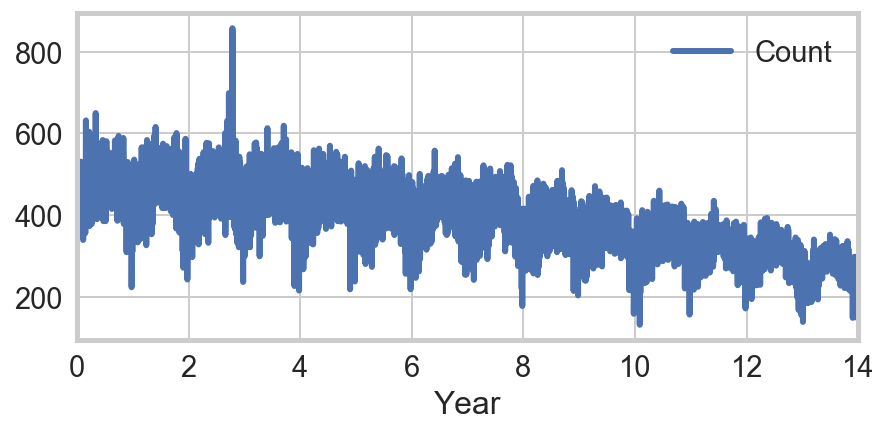

In [46]:
ct_mdw.plot(x = "Year", y = "Count")

In [30]:
ols = smf.ols(formula = "NC ~ Year + T + C(DoW)",
              data = ct_mdw.rename(columns = {"Count" : "NC", 
                                              "Temperature [F]" : "T"}))
model = ols.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     NC   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     3503.
Date:                Wed, 22 Nov 2017   Prob (F-statistic):               0.00
Time:                        01:34:52   Log-Likelihood:                -28995.
No. Observations:                5762   AIC:                         5.801e+04
Df Residuals:                    5753   BIC:                         5.807e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     443.9982      2.010    220.881      0.000     440.058     447.939
C(DoW)[T.1]    11.9083      1.829      6.511      0.000       8.323      15.493
C(DoW)[T.2]    16.5307      1.829      9.039      0.000      12.945      20.116
C(DoW)[T.3]    10.8303      1.830      5.918      0.000       7.243      14.418
C(DoW)[T.4]    35.8658      1.830     19.603      0.000      32.279      39.453
C(DoW)[T.5]   -17.6645      1.830     -9.655      0.000     -21.251     -14.078
C(DoW)[T.6]   -54.9970      1.829    -30.063      0.000     -58.583     -51.411
Year          -16.3165      0.107   -151.944      0.000     -16.527     -16.106
T               1.2235      0.025     49.087      0.000       1.175       1.272
==============================================================================
Omnibus:                      674.362   Durbin-Watson:                   1.306
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6692.895
Skew:                           0.097   Prob(JB):                         0.00
Kurtosis:                       8.276   Cond. No.                         424.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

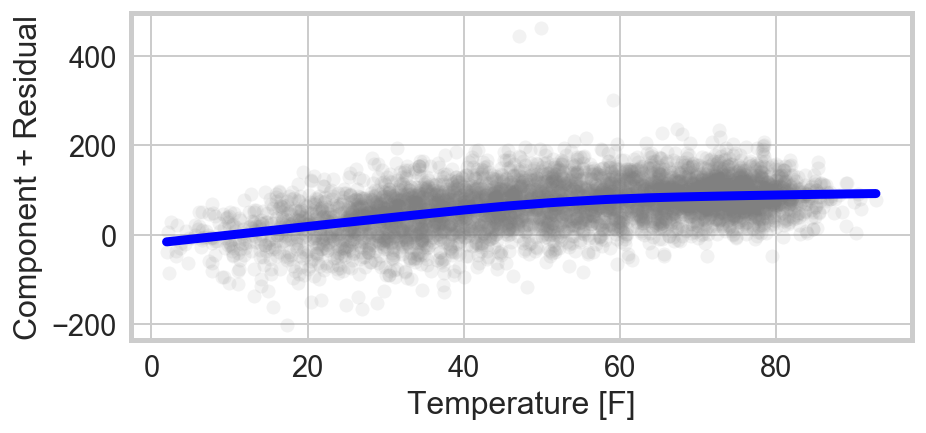

In [49]:
cpr = pd.Series(name = "Component + Residual", data = model.resid + ct_mdw["Temperature [F]"] * model.params["T"])
sns.regplot(x = ct_mdw["Temperature [F]"], y = cpr, lowess = True, 
            scatter_kws = {"alpha" : 0.1, "color" : "grey"}, line_kws = {"color" : "blue"});

We are now fitting the piecewise function,
$$Crime \sim \alpha + \beta_Y Y + \begin{cases}
             \beta_T T  & \text{if } T < T_\text{cut} \\
             \beta_T T_\text{cut} + \beta_{T,\text{high}} (T-T_\text{cut})  & \text{if } T \ge T_\text{cut}
       \end{cases}$$

This is the entire interest of this project: we can fit a function with an arbitrary "kink."

In [50]:
def residual_kink(vars, T, Y, data):
    
    base   = vars["base"]
    Tcut   = vars["Tcut"]
    betaT  = vars["betaT"]
    betaTh = vars["betaTh"]
    betaY  = vars["betaY"]

    model = base + Y * betaY + np.where(T < Tcut, T * betaT, Tcut*betaT + (T - Tcut) * betaTh) 

    return (data - model) / np.sqrt(data)


params = Parameters()
params.add('betaT', value = 1,  min = 0, max = 10)
params.add('betaTh', value = 0,  min =-3, max = 3)
params.add('betaY', value = -15.6,  min = -50, max = 0)
params.add('Tcut', value = 70,  min = 0, max = 120)
params.add('base', value = 443.2, min = 300, max = 700)

out = minimize(residual_kink, params, 
               args=(ct_mdw["Temperature [F]"], ct_mdw["Year"], ct_mdw["Count"]),
               method = "leastsq")

report_fit(out)

[[Fit Statistics]]
    # function evals   = 75
    # data points      = 5112
    # variables        = 5
    chi-square         = 29702.555
    reduced chi-square = 5.816
    Akaike info crit   = 9005.292
    Bayesian info crit = 9037.988
[[Variables]]
    betaT:    2.10085525 +/- 0.088669 (4.22%) (init= 1)
    betaTh:   0.60355303 +/- 0.093548 (15.50%) (init= 0)
    betaY:   -15.7796533 +/- 0.160385 (1.02%) (init=-15.6)
    Tcut:     49.4351642 +/- 1.724025 (3.49%) (init= 70)
    base:     405.188737 +/- 3.307297 (0.82%) (init= 443.2)
[[Correlations]] (unreported correlations are <  0.100)
    C(betaT, base)               = -0.883 
    C(betaTh, Tcut)              = -0.635 
    C(betaT, Tcut)               = -0.583 
    C(Tcut, base)                =  0.408 
    C(betaY, base)               = -0.400 


The quadratic model has had some problems with convergence, but seems to be working...

In [51]:
params = Parameters()
params.add('betaT', value = 0,  min = -5, max = 5)
params.add('betaY', value = -13.3,  min = -100, max = 0)
params.add('Topt', value = 50,  min = 0,  max = 200)
params.add('base', value = 500, min = 200, max = 700)

def residual_quad(vars, T, Y, data):
    
    base  = vars["base"]
    Topt  = vars["Topt"]
    betaT = vars["betaT"]
    betaY = vars["betaY"]

    model = base + np.power(Topt - T, 2) * betaT + Y * betaY

    return (data - model) / np.sqrt(data)


out = minimize(residual_quad, params, 
               args=(ct_mdw["Temperature [F]"], ct_mdw["Year"], ct_mdw["Count"]),
               method = "leastsq")

report_fit(out)

[[Fit Statistics]]
    # function evals   = 28
    # data points      = 5112
    # variables        = 4
    chi-square         = 29742.216
    reduced chi-square = 5.823
    Akaike info crit   = 9010.113
    Bayesian info crit = 9036.270
[[Variables]]
    betaT:  -0.01897921 +/- 0.001674 (8.82%) (init= 0)
    betaY:  -15.7721482 +/- 0.160488 (1.02%) (init=-13.3)
    Topt:    84.5276899 +/- 3.260687 (3.86%) (init= 50)
    base:    527.075961 +/- 2.326779 (0.44%) (init= 500)
[[Correlations]] (unreported correlations are <  0.100)
    C(betaT, Topt)               =  0.964 
    C(Topt, base)                =  0.746 
    C(betaT, base)               =  0.643 
    C(betaY, base)               = -0.550 
